In [1]:
import pandas as pd
import pandahouse as ph
import scipy.stats as stats
from scipy.stats import ttest_ind
import seaborn as sns
import numpy as np
import hashlib
import matplotlib.pyplot as plt

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-24' and '2023-01-30'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


In [ ]:
# Группы поделены равномерно, это хорошо

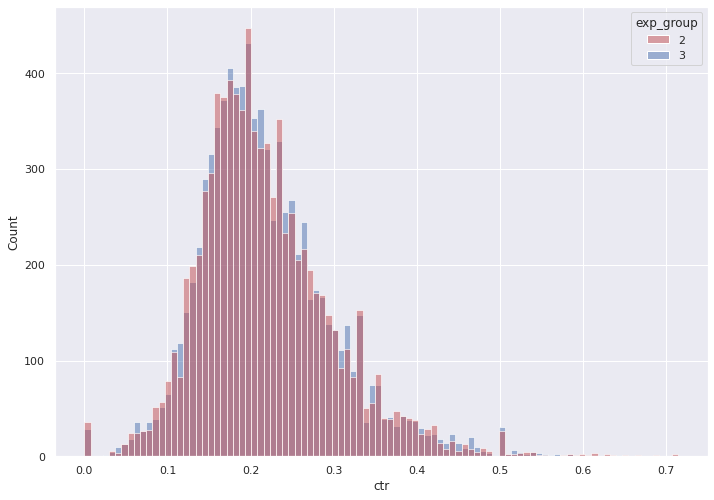

In [3]:
# Сделаем графики в seaborn
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [4]:
# генерация 10 000 подвыборок без повторения из 500 пользователей из двух групп. T-test. Расчет p-value
p_test = []
for i in range(10000):
    s,p =stats.ttest_ind(df[df.exp_group == 2].ctr.sample(500, replace=False),
                         df[df.exp_group == 3].ctr.sample(500, replace=False),
                         equal_var=False)
    p_test.append (p)

In [5]:
len(p_test)

10000

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

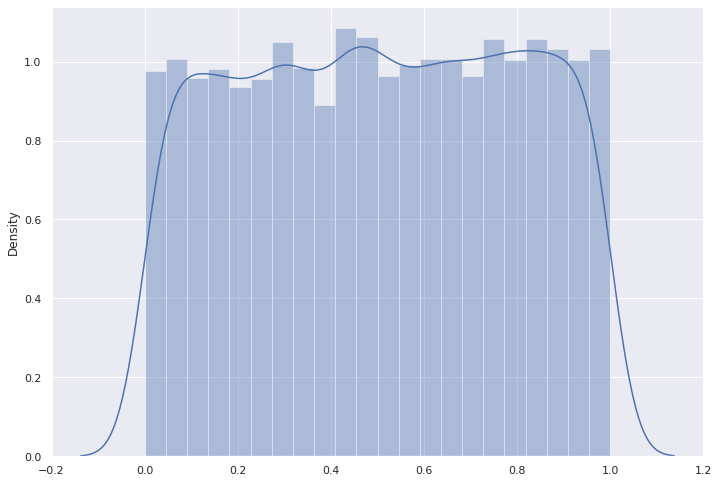

In [6]:
sns.distplot(p_test)

In [7]:
p_low=len([i for i in p_test if i <= 0.05])
p_low

493

In [8]:
print(f'p-value меньше чем 0.05 в {p_low / 10000 * 100}% случаях.')

p-value меньше чем 0.05 в 4.93% случаях.


In [ ]:
# Система сплитирования работает корректно, наши выборки различаются только в 4,95% случаев. Мы можем проводить А/Б тест.